In [493]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from util import *
%matplotlib inline

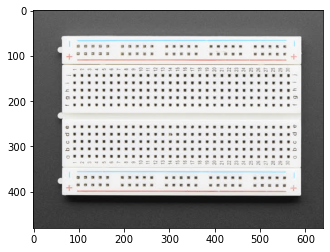

In [624]:
img = cv2.imread('images/breadboard_plain.jpeg')
#img = cv2.imread('images/simple.jpg')
#img = cv2.imread('images/bb1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display img
plt.imshow(img)
plt.show()


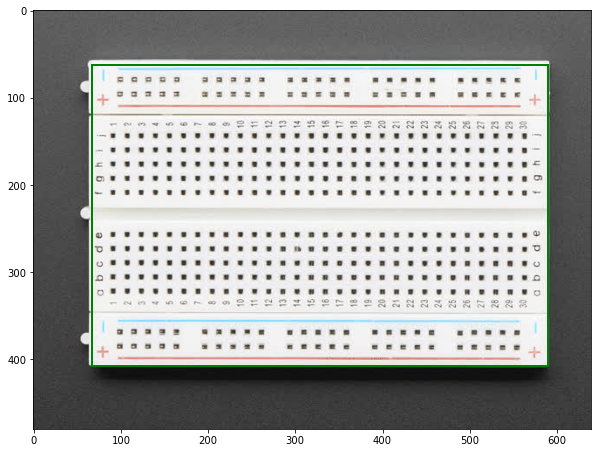

In [625]:
input_boxes = [[67, 62, 590, 407]]
#input_boxes = [[129, 115, 1717, 1108]]
#input_boxes = [[30, 103, 468, 389]]
show_boxes_on_image(img, input_boxes)

In [626]:
class Breadboard:
    # i might need to initialize the grid w.r.t with the breadboard coordinates, not image coordinates
    # because in the future, i might combine multiple images
    # connection should have a name
    
    def __init__(self, has_power_rails=True, grid=None):
        self.has_power_rails = has_power_rails
        self.num_rows = 10 # not including power rails
        self.num_cols = None # not including power rails
        self.grid = grid # middle of the breadboard (no power rails)

In [627]:
def identify_raw_keypoints(img, bounding_box):

    # identify blobs in the image and constrain them to the input boxes
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(img)

    # delete keypoints if they are not in the input boxes
    keypoints = [kp for kp in keypoints if kp.pt[0] > input_boxes[0][0] and kp.pt[0] < input_boxes[0][2] and kp.pt[1] > input_boxes[0][1] and kp.pt[1] < input_boxes[0][3]]

    # sort keypoints by y coordinate
    keypoints.sort(key=lambda x: x.pt[1])
    keypoints = [kp.pt for kp in keypoints]
    keypoints = np.array(keypoints, dtype=np.int32)

    # print the total number of keypoints
    show_points_on_image(img, keypoints)
    print("Total number of keypoints: {}".format(len(keypoints)))

    return keypoints

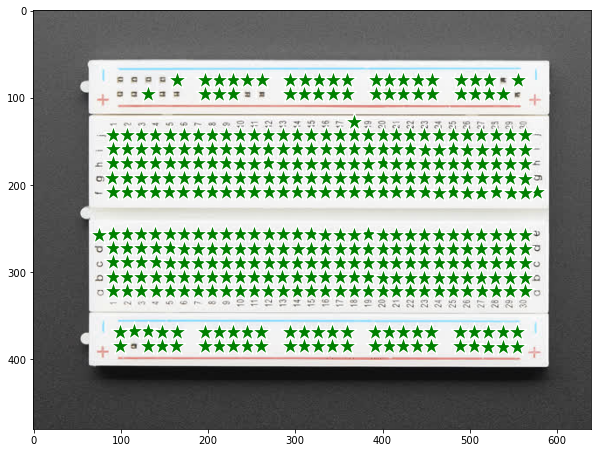

Total number of keypoints: 390


In [628]:
raw_keypoints = identify_raw_keypoints(img, input_boxes)

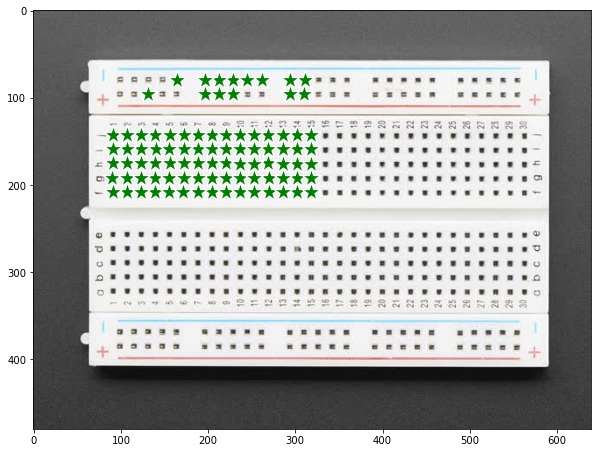

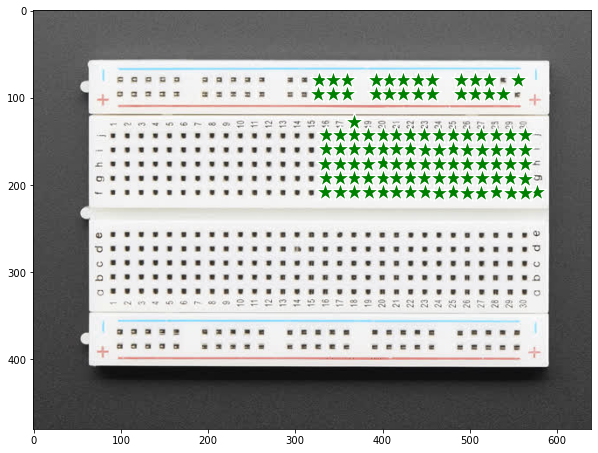

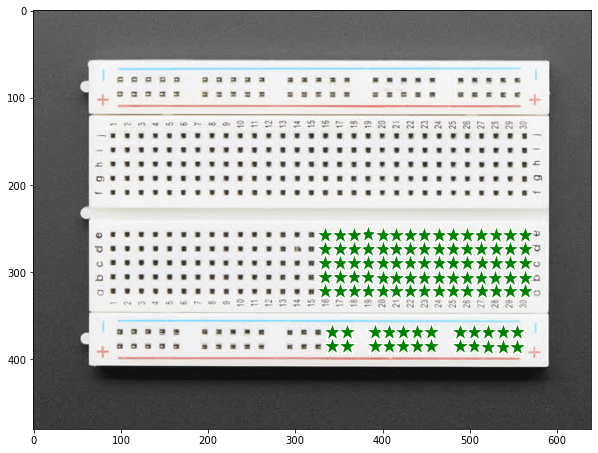

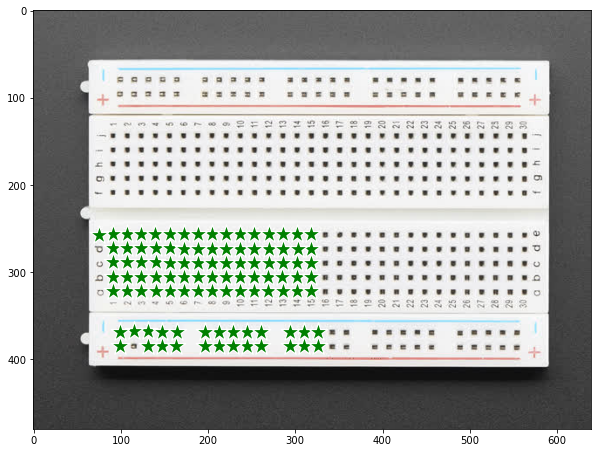

In [629]:
def cluster_keypoint(raw_keypoints):
    # perform clustering
    num_clusters = 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(raw_keypoints)
    labels = kmeans.labels_
    # create sub-arrays within data to cluster according to the labels
    clusters = []
    for i in range(num_clusters):
        cluster = raw_keypoints[labels == i]
        clusters.append(cluster)

    # sort the clusters from left to right, top to bottom
    clusters.sort(key=lambda x: x[0][1])

    show_points_on_image(img, clusters[0])
    show_points_on_image(img, clusters[1])
    show_points_on_image(img, clusters[2])
    show_points_on_image(img, clusters[3])

clustered_keypoints = cluster_keypoint(raw_keypoints)

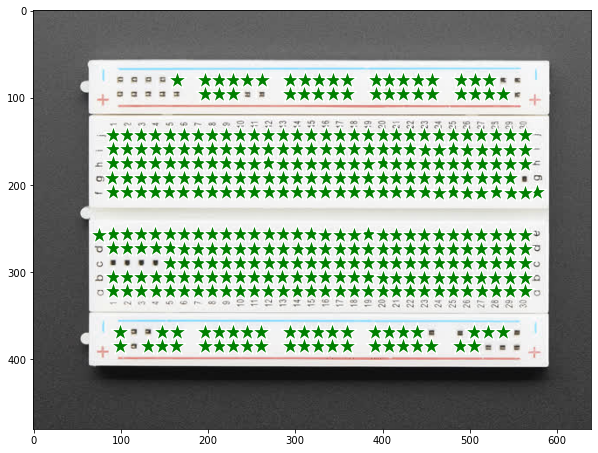

In [589]:
def process_keypoints(raw_keypoints):
    # removing outliers
    # count unique y coordinates and how many times they appear
    # save as array of tuples (y, count)
    x_counts = np.unique(raw_keypoints[:, 0], return_counts=True)
    x_counts = np.array(x_counts).T
    y_counts = np.unique(raw_keypoints[:, 1], return_counts=True)
    y_counts = np.array(y_counts).T

    #print("x_counts:\n {}".format(x_counts))
    #print("y_counts:\n {}".format(y_counts))

    # assemble a dictionary, where the key is the y coordinate and the value is a list of x coordinates
    # for example {79: [229, 262, 327, ...]}
    y_dict = {}
    for y_count in y_counts:
        y = y_count[0]
        count = y_count[1]
        x_coords = raw_keypoints[raw_keypoints[:, 1] == y][:, 0]
        x_coords.sort()
        y_dict[y] = x_coords

    #print("y_dict:\n {}".format(y_dict))

    # assemble a similar dictionary, but for x coordinates
    x_dict = {}
    for x_count in x_counts:
        x = x_count[0]
        count = x_count[1]
        y_coords = raw_keypoints[raw_keypoints[:, 0] == x][:, 1]
        y_coords.sort()
        x_dict[x] = y_coords

    y_values = list(y_dict.keys())

    # from sorted y_values, find the distances between neighboring y_values
    distances = {}
    for i in range(len(y_values) - 1):
        distance = y_values[i+1] - y_values[i]
        # count is how many elements that y_value has in y_dict
        count = len(y_dict[y_values[i]])
        if count < 5:
            continue
        distances[y_values[i]] = [distance, count]
    distances = sorted(distances.items(), key=lambda x: x[1][1], reverse=True)
    # sort by key
    distances = sorted(distances, key=lambda x: x[0])
    #print("distances:\n {}".format(distances))

    temp_keypoints = []
    for distance in distances:
        y = distance[0]
        x_coords = y_dict[y]
        for x in x_coords:
            temp_keypoints.append((x, y))

    show_points_on_image(img, temp_keypoints)

    return temp_keypoints


processed_keypoints = process_keypoints(raw_keypoints)

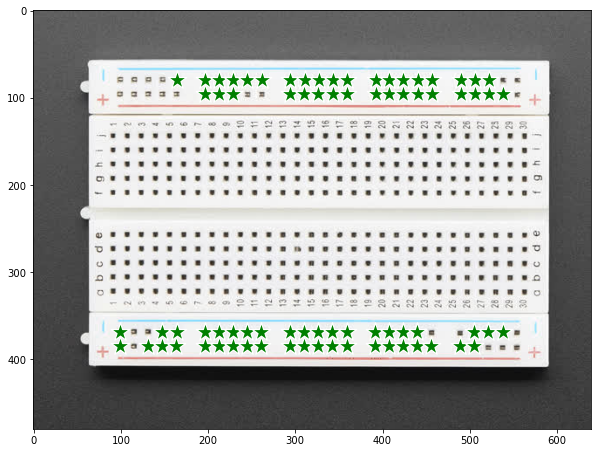

In [590]:
def detect_power_rails(processed_keypoints):
    kps = processed_keypoints.copy()
    # sort kps by y coordinate
    kps.sort(key=lambda x: x[1])
    
    y_coords = [kp[1] for kp in kps]
    y_coords = np.unique(y_coords)

    y_rails = []
    y_counter = 0
    for rail_count in range(2):
        rail = []
        y_coord = y_coords[y_counter]
        rail.append(y_coord)
        neighbor = y_coords[y_counter + 1]
        if neighbor - y_coord < 3:
            rail.append(neighbor)
            y_counter += 2
        else:
            y_counter += 1
        y_rails.append(rail)

    y_counter = -1
    for rail_count in range(2):
        rail = []
        y_coord = y_coords[y_counter]
        rail.append(y_coord)
        neighbor = y_coords[y_counter - 1]
        if y_coord - neighbor < 3:
            rail.append(neighbor)
            y_counter -= 2
        else:
            y_counter -= 1
        y_rails.append(rail)

    # return an array of 4 elements, each of which contains (x, y) coordinates corresponding to the power rail
    rails = []
    for y_rail in y_rails:
        rail = []
        # rail will contain (x, y) coordinates corresponding to the power rail
        # takes all values corresponding to the y_rail key
        rail = [kp for kp in kps if kp[1] in y_rail]

        # sort rail by x coordinate
        rail.sort(key=lambda x: x[0])
        rails.append(rail)

    rail_keypoints = []
    for i in range(len(rails)):
        for j in range(len(rails[i])):
            rail_keypoints.append(rails[i][j])

    show_points_on_image(img, rail_keypoints)

    #grid_keypoints = [kp for kp in kps if kp not in rail_keypoints]
    #show_points_on_image(img, grid_keypoints)
    
    return rails
    
rails = detect_power_rails(processed_keypoints)

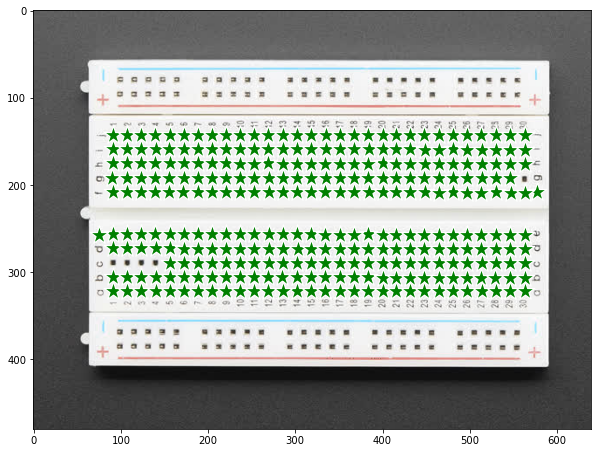

counters: [30, 30, 30, 30, 30, 1, 1, 1, 1, 1]
connect: [(75, 257), (91, 272), (156, 289), (91, 305), (91, 321)]
x_avg: 100.8
here
counters: [30, 30, 30, 30, 30, 1, 1, 0, 1, 1]
connect: [(75, 257), (91, 272), None, (91, 305), (91, 321)]

counters: [30, 30, 30, 30, 30, 2, 2, 1, 2, 2]
connect: [(91, 256), (107, 272), (156, 289), (107, 305), (107, 321)]
x_avg: 113.6
here
counters: [30, 30, 30, 30, 30, 2, 2, 0, 2, 2]
connect: [(91, 256), (107, 272), None, (107, 305), (107, 321)]

counters: [30, 30, 30, 30, 30, 3, 3, 1, 3, 3]
connect: [(107, 256), (123, 272), (156, 289), (123, 305), (123, 321)]
x_avg: 126.4
here
counters: [30, 30, 30, 30, 30, 3, 3, 0, 3, 3]
connect: [(107, 256), (123, 272), None, (123, 305), (123, 321)]

counters: [30, 30, 30, 30, 30, 4, 4, 1, 4, 4]
connect: [(123, 256), (140, 272), (156, 289), (140, 305), (140, 321)]
x_avg: 139.8
counters: [30, 30, 30, 30, 30, 4, 4, 1, 4, 4]
connect: [(123, 256), (140, 272), (156, 289), (140, 305), (140, 321)]

counters: [30, 30, 30, 30, 30

In [591]:
def detect_grid(processed_keypoints, rails):
    rail_keypoints = []
    for i in range(len(rails)):
        for j in range(len(rails[i])):
            rail_keypoints.append(rails[i][j])
    
    grid_keypoints = [kp for kp in processed_keypoints if kp not in rail_keypoints]
    show_points_on_image(img, grid_keypoints)

    # sort grid_keypoints by y coordinate
    grid_keypoints.sort(key=lambda x: x[1])
    
    y_coords = [kp[1] for kp in grid_keypoints]
    y_coords = np.unique(y_coords)
    y_coords = np.array(y_coords)

    # perform clustering
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(y_coords.reshape(-1, 1))
    labels = kmeans.labels_
    # create sub-arrays within data to cluster according to the labels
    y_clusters = []
    for i in range(num_clusters):
        cluster = y_coords[labels == i]
        y_clusters.append(cluster)
    # sort the clusters
    y_clusters.sort(key=lambda x: x[0])

    grid_rows = []
    for cluster in y_clusters:
        row = []
        for y_coord in cluster:
            set_of_pts = [kp for kp in grid_keypoints if kp[1] == y_coord]
            row += set_of_pts
        grid_rows.append(row)

    # sort grid_rows by x coordinate
    for i in range(len(grid_rows)):
        grid_rows[i].sort(key=lambda x: x[0])

    grid_connects = []
    counters = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(30):
        connect = []
        for j in range(5):
            if counters[j] < len(grid_rows[j]):
                connect.append(grid_rows[j][counters[j]])
            else:
                connect.append(None)
        # increment counters by 1 (each element)
        for j in range(5):
            counters[j] += 1
        # compute the average x coordinate of the 5 points (not including None)
        x_coords = [connect[j][0] for j in range(5) if connect[j] is not None]
        x_avg = sum(x_coords) / len(x_coords)
        # if a point is within 3 pixels of the average x coordinate, keep it
        for j in range(5):
            if connect[j] is not None and abs(connect[j][0] - x_avg) > 3:
                connect[j] = None
                counters[j] -= 1
        grid_connects.append(connect)

    for i in range(30):
        connect = []
        for j in range(5, 10):
            if counters[j] < len(grid_rows[j]):
                connect.append(grid_rows[j][counters[j]])
            else:
                connect.append(None)

        for j in range(5):
            counters[j+5] += 1

        print("counters: {}".format(counters))
        print("connect: {}".format(connect))
        # compute the average x coordinate of the 5 points (not including None)
        x_coords = [connect[j][0] for j in range(5) if connect[j] is not None]
        x_avg = sum(x_coords) / len(x_coords)
        print("x_avg: {}".format(x_avg))
        # if all points are too far from the average
        if all([abs(connect[j][0] - x_avg) > 3 for j in range(5) if connect[j] is not None]):
            # set the points with x coordinate bigger than average to None
            for j in range(5):
                if connect[j] is not None and connect[j][0] > x_avg:
                    connect[j] = None
                    counters[j+5] -= 1
                    print("here")
        print("counters: {}".format(counters))
        print("connect: {}\n".format(connect))
        grid_connects.append(connect)

    return grid_connects
    
grid_connects = detect_grid(processed_keypoints, rails)
print(grid_connects)

In [542]:
for elem in grid_connects:
    # draw the line connecting the two farther points
    # find the two farther points
    # sort the points by y coordinate
    # ignore None
    elem.sort(key=lambda x: x[1])
    #print(elem)

    # find the two farther points
    farther_points = []
    for i in range(5):
        if elem[i] is not None:
            farther_points.append(elem[i])
    farther_points.sort(key=lambda x: x[1])
    #print(farther_points)

    # draw the line
    cv2.line(img, farther_points[0], farther_points[1], (0, 255, 0), 2)
    

plt.imshow(img)
plt.show()

# save the image
cv2.imwrite('images/bb_processed.jpg', img)


TypeError: 'NoneType' object is not subscriptable